# Finite Strain 
[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meyer-nils/torch-fem/blob/main/examples/basic/planar/finite_strain.ipynb)

We compare small-strain and finite-strain material models for a plate with a hole.

In [1]:
import torch

import matplotlib.pyplot as plt
import numpy as np
from torchfem.examples import get_example_file
from torchfem.io import import_mesh
from torchfem.materials import (
    IsotropicElasticityPlaneStress,
    IsotropicSaintVenantKirchhoffPlaneStress,
)

# Set default data type to double precision
torch.set_default_dtype(torch.float64)

# Dimensions (thickness of plate t and edge length L)
t = 0.01
L = 0.2

# Incremental loading
increments = torch.linspace(0.0, 1.0, 21)
DU = 0.09

## Small strain isotropic elasticity without geometric non-linearity

In [2]:
# Material model (plane stress)
material = IsotropicElasticityPlaneStress(E=1000.0, nu=0.3)

# Import mesh
plate = import_mesh(get_example_file("plate_hole.vtk"), material)
plate.thickness[:] = t

# Fixed boundary at left end
left = plate.nodes[:, 0] < 1e-6
plate.constraints[left] = True

# Load at right end
right = plate.nodes[:, 0] > L - 1e-6
plate.constraints[right] = True
plate.displacements[right, 0] = DU

# Solve
u, f, σ, F, _ = plate.solve(increments=increments, return_intermediate=True)

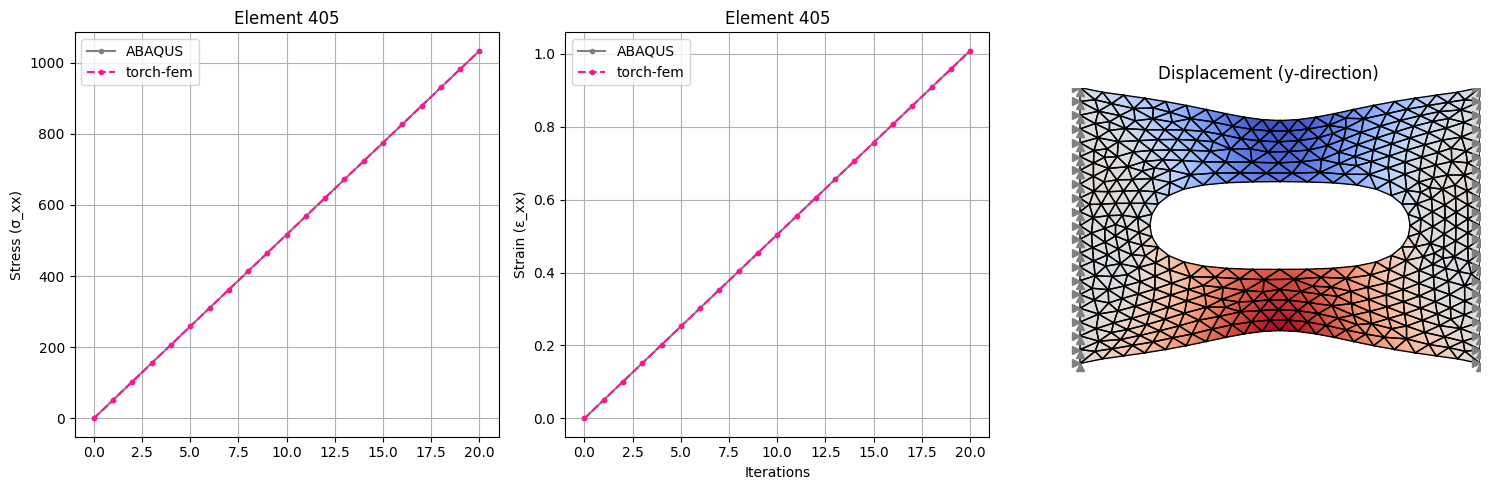

In [3]:
ref_data = np.array(
    [
        [0.000000, 0.00000],
        [0.050427, 51.6634],
        [0.100854, 103.327],
        [0.151280, 154.990],
        [0.201707, 206.654],
        [0.252134, 258.317],
        [0.302561, 309.981],
        [0.352988, 361.644],
        [0.403415, 413.308],
        [0.453841, 464.971],
        [0.504268, 516.634],
        [0.554695, 568.298],
        [0.605122, 619.961],
        [0.655549, 671.625],
        [0.705975, 723.288],
        [0.756402, 774.952],
        [0.806829, 826.615],
        [0.857256, 878.279],
        [0.907683, 929.942],
        [0.958109, 981.605],
        [1.008540, 1033.27],
    ]
)


fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(ref_data[:, 1], ".-", color="gray", label="ABAQUS")
ax[0].plot(σ[:, 405, 0, 0], ".--", color="deeppink", label="torch-fem")
ax[0].grid()
ax[0].title.set_text("Element 405")
ax[0].set_ylabel("Stress (σ_xx)")
ax[0].legend()

ε = 0.5 * (F.transpose(-1, -2) + F) - torch.eye(2)
ax[1].plot(ref_data[:, 0], ".-", color="gray", label="ABAQUS")
ax[1].plot(ε[:, 405, 0, 0], ".--", color="deeppink", label="torch-fem")
ax[1].grid()
ax[1].title.set_text("Element 405")
ax[1].set_ylabel("Strain (ε_xx)")
ax[1].legend()
ax[1].set_xlabel("Iterations")

plate.plot(
    u=u[-1],
    node_property=u[-1, :, 1],
    cmap="coolwarm",
    title="Displacement (y-direction)",
    ax=ax[2],
)
plt.tight_layout()
plt.show()

## Isotropic Saint Venant-Kirchhoff material with geometric non-linearity

In [4]:
# Material model (plane stress)
material = IsotropicSaintVenantKirchhoffPlaneStress(E=1000.0, nu=0.3)

# Import mesh
plate = import_mesh(get_example_file("plate_hole.vtk"), material)
plate.thickness[:] = t

# Fixed boundary at left end
left = plate.nodes[:, 0] < 1e-6
plate.constraints[left] = True

# Load at right end
right = plate.nodes[:, 0] > L - 1e-6
plate.constraints[right] = True
plate.displacements[right, 0] = DU

# Solve
u, f, S, F, _ = plate.solve(increments=increments, return_intermediate=True)

# Post-process
J = torch.det(F)[..., None, None]
σ = F @ S @ F.transpose(-1, -2) / J
C = F.transpose(-1, -2) @ F
ev, Q = torch.linalg.eigh(C)
LE = 0.5 * Q @ torch.diag_embed(torch.log(ev)) @ Q.transpose(-1, -2)

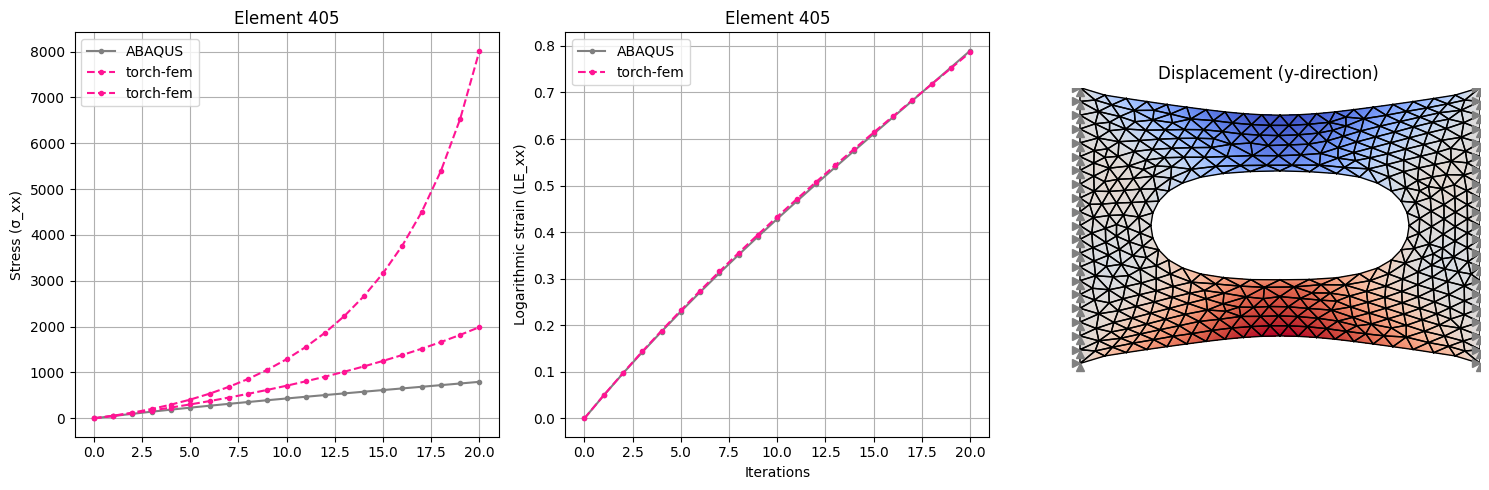

In [5]:
ref_data = np.array(
    [
        [0.000000, 0.00000],
        [0.049178, 50.2331],
        [0.096586, 98.4926],
        [0.142239, 144.831],
        [0.186524, 189.674],
        [0.229460, 233.065],
        [0.271194, 275.175],
        [0.311846, 316.140],
        [0.351536, 356.095],
        [0.390373, 395.160],
        [0.428462, 433.450],
        [0.465902, 471.073],
        [0.502789, 508.130],
        [0.539216, 544.722],
        [0.575276, 580.946],
        [0.611064, 616.903],
        [0.646676, 652.694],
        [0.682218, 688.431],
        [0.717806, 724.234],
        [0.753571, 760.242],
        [0.789677, 796.628],
    ]
)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(ref_data[:, 1], ".-", color="gray", label="ABAQUS")
ax[0].plot(S[:, 405, 0, 0], ".--", color="deeppink", label="torch-fem")
ax[0].plot(σ[:, 405, 0, 0], ".--", color="deeppink", label="torch-fem")
ax[0].grid()
ax[0].title.set_text("Element 405")
ax[0].set_ylabel("Stress (σ_xx)")
ax[0].legend()
ax[1].plot(ref_data[:, 0], ".-", color="gray", label="ABAQUS")
ax[1].plot(LE[:, 405, 0, 0], ".--", color="deeppink", label="torch-fem")
ax[1].grid()
ax[1].title.set_text("Element 405")
ax[1].set_ylabel("Logarithmic strain (LE_xx)")
ax[1].legend()
ax[1].set_xlabel("Iterations")

plate.plot(
    u=u[-1],
    node_property=u[-1, :, 1],
    cmap="coolwarm",
    title="Displacement (y-direction)",
    ax=ax[2],
)
plt.tight_layout()
plt.show()